In [1]:
import jax.numpy as jnp
import jax
from jax.scipy import optimize
jax.config.update("jax_enable_x64", True)
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

import numpy as np
import scipy
import matplotlib.pyplot as plt

import sys, os

2024-05-31 19:05:00.810882: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
sys.path.insert(0, "/home/storage/hans/jax_reco")
from lib.cgamma import _c_gamma_region1
from lib.cgamma import _c_gamma_region3
from lib.cgamma import _c_gamma_region4
from lib.cgamma import c_gamma_prob

In [3]:
from lib.plotting_tools import adjust_plot_1d
from lib.network import get_network_eval_fn
from lib.geo import get_xyz_from_zenith_azimuth
from lib.trafos import transform_network_outputs, transform_network_inputs

In [4]:
eval_network = get_network_eval_fn(bpath='/home/storage/hans/jax_reco/data/network')

In [5]:
# Set choice of parameters.

dist = 10
z = -210
rho = 0.0
zenith = np.pi/2
azimuth = 0.0

x = jnp.array([dist, rho, z, zenith, azimuth])
x_prime = transform_network_inputs(x)
y = eval_network(x_prime)
logits, gamma_a, gamma_b = transform_network_outputs(y)

# index 1 is main component
gamma_a = gamma_a[1]
gamma_b = gamma_b[1]
#gamma_a = 3.5
#gamma_b = 0.8
sigma = 3

xmax = 10 * dist

print(gamma_a, gamma_b)

3.609988410139153 0.8048957943430097


In [6]:
key = jax.random.PRNGKey(1)

In [21]:
n_samples = 30

gamma = tfd.Gamma(concentration=gamma_a, rate=gamma_b, 
                  force_probs_to_zero_outside_support=True)

key, subkey = jax.random.split(key)
data = gamma.sample(n_samples, seed = subkey)

norm = tfd.Normal(loc=0, scale=sigma)
key, subkey = jax.random.split(key)
jitter = norm.sample(n_samples, seed = subkey)

noisy_data = data + jitter

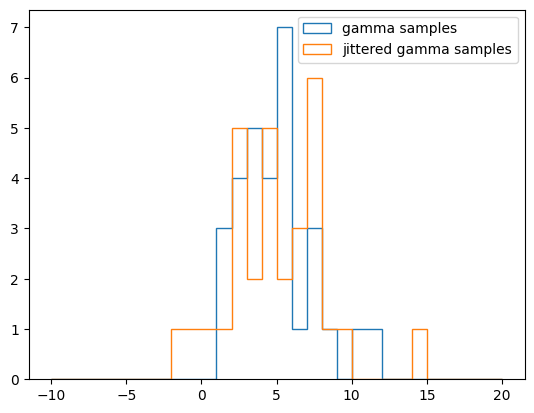

In [22]:
fig, ax = plt.subplots()
bins = np.linspace(-10, 20, 31)
ax.hist(data, bins=bins, histtype='step', label='gamma samples')
ax.hist(noisy_data, bins=bins, histtype='step', label='jittered gamma samples')
ax.legend()
plt.show()

In [31]:
@jax.jit
def likelihood(x, data):
    a = x[0]
    b = x[1]
    probs = c_gamma_prob(data, a, b, sigma=sigma)
    return -jnp.sum(jnp.log(probs))  

likelihood_v = jax.jit(jax.vmap(likelihood, (0, None), 0))

In [24]:
print(likelihood(jnp.array([gamma_a, gamma_b]), noisy_data))

78.85833906330244


In [27]:
@jax.jit
def minimize(x0):
    return jax.scipy.optimize.minimize(likelihood, x0, args=(noisy_data,), method="BFGS", tol=1.e-10)

In [74]:
print(minimize(jnp.array([7.5, 1.5])))

OptimizeResults(x=Array([10.24980448,  2.03924744], dtype=float64), success=Array(False, dtype=bool), status=Array(5, dtype=int64, weak_type=True), fun=Array(78.06460338, dtype=float64), jac=Array([ 0.00053733, -0.00246533], dtype=float64), hess_inv=None, nfev=Array(67, dtype=int64, weak_type=True), njev=Array(67, dtype=int64, weak_type=True), nit=Array(11, dtype=int64, weak_type=True))


In [13]:
print(gamma_a, gamma_b)

3.609988410139153 0.8048957943430097


In [63]:
ra, rb = (10.24036914,  2.0373306 )

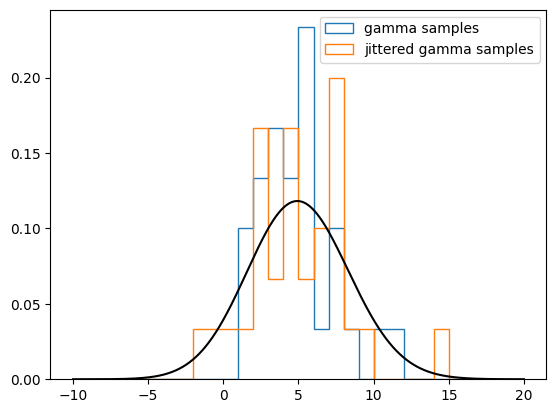

In [64]:
fig, ax = plt.subplots()
bins = np.linspace(-10, 20, 31)
ax.hist(data, bins=bins, histtype='step', label='gamma samples', density=True)
ax.hist(noisy_data, bins=bins, histtype='step', label='jittered gamma samples', density=True)
xvals = np.linspace(-10, 20, 10000)
yvals = c_gamma_prob(xvals, ra, rb, sigma=sigma)
ax.plot(xvals, yvals, "k-")
ax.legend()
plt.show()

In [60]:
# And plot likelihood space.
n_eval = 100
gas = np.linspace(gamma_a-2.6, gamma_a+10, n_eval)
gbs = np.linspace(gamma_b-0.5, gamma_b+2.0, n_eval)
X, Y = np.meshgrid(gas, gbs)

grids = jnp.column_stack([X.flatten(), Y.flatten()])
logls = likelihood_v(grids, noisy_data)
logls = logls.reshape(X.shape)

/tmp/ipykernel_133247/1558039519.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


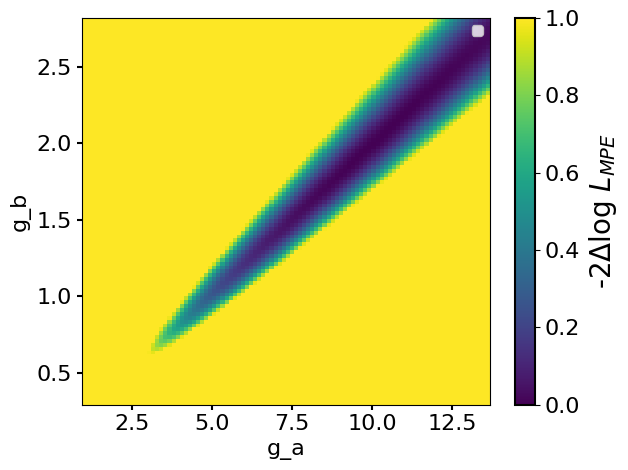

In [61]:
fig, ax = plt.subplots()
min_logl = np.amin(logls)
delta_logl = logls - np.amin(logls)
pc = ax.pcolormesh(X, Y, delta_logl, 
                   vmin=0, vmax=1, shading='auto')
cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("-2$\\Delta$log $L_{MPE}$", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("g_a", fontsize=16)
ax.set_ylabel("g_b", fontsize=16)
#ax.set_xlim(np.rad2deg([track_src[0]-0.01, track_src[0]+0.01]))
#ax.set_ylim(np.rad2deg([track_src[1]-0.01, track_src[1]+0.01]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

plt.legend()
plt.tight_layout()
plt.show()

In [59]:
logls

Array([[ 83.65397168,  83.01443018,  82.48926458, ..., 218.0909995 ,
        220.4561386 , 222.83302037],
       [ 84.14004322,  83.41179808,  82.79406233, ..., 205.28818436,
        207.50031327, 209.72404566],
       [ 84.70975006,  83.90602488,  83.20899611, ..., 193.8804655 ,
        195.95311832, 198.03723524],
       ...,
       [114.09151276, 113.61656205, 113.14552613, ...,  83.81145218,
         83.64487451,  83.4809261 ],
       [114.15627366, 113.68555191, 113.21866662, ...,  83.98959876,
         83.82175318,  83.65649748],
       [114.21957046, 113.75304978, 113.29028186, ...,  84.16744849,
         83.99839907,  83.8319012 ]], dtype=float64)

In [48]:
@jax.jit
def minimize(x0):
    return jax.scipy.optimize.minimize(likelihood, x0, args=(noisy_data,), method="l-bfgs-experimental-do-not-rely-on-this", tol=1.e-10)

In [62]:
print(minimize(jnp.array([12.0, 2.0])))

OptimizeResults(x=Array([10.24036914,  2.0373306 ], dtype=float64), success=Array(True, dtype=bool), status=Array(0, dtype=int64, weak_type=True), fun=Array(78.06460317, dtype=float64), jac=Array([-8.86494901e-06,  3.00744618e-06], dtype=float64), hess_inv=None, nfev=Array(20, dtype=int64, weak_type=True), njev=Array(20, dtype=int64, weak_type=True), nit=Array(17, dtype=int64, weak_type=True))
